## Data files 

mofid_test.cvs/.json - normalized dictionary of MOFid

test.csv/.json - normalized all data (mofid, mofkey, space group, cell parameter, organic linker, metal node and etc.)

func.py - script for normalization raw data 

In [1]:
import pandas as pd 

# Import comet_ml at the top of your file
# from comet_ml import Experiment

import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Data preparing 

In [2]:
# Import the dataset and split it into train and test
data = pd.read_csv('03_04_prepare.csv', index_col=0)
train_dataset, test_dataset = train_test_split(data, test_size=0.2)


In [3]:
train_dataset

,simples_nodes,simples_linkers,simples,topology,cat,a,b,c,alpha,beta,gamma,cell volume,space group
cifname,,,,,,,,,,,,,
7707445,0.990315,0.979070,0.977817,0.425339,0.000000,0.453719,0.453837,0.118926,0.515868,0.354983,1.000000,0.036929,0.536585
4001442,0.009685,0.102326,0.085182,0.063348,0.000000,0.208275,0.107089,0.086972,0.515868,0.809903,0.480222,0.003955,0.085366
7042996,0.106538,0.738372,0.732032,0.343891,0.000000,0.107875,0.108069,0.244475,0.515868,0.354983,1.000000,0.005708,0.810976
7040400,0.142857,0.730233,0.718722,0.004525,0.000000,0.073593,0.112960,0.085455,0.283132,0.286462,0.471161,0.001938,0.060976
4125917,0.009685,0.273256,0.244898,0.063348,0.000000,0.246187,0.110690,0.042876,0.515868,0.380536,0.480222,0.003488,0.085366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028436,0.697337,0.689535,0.673469,0.000000,0.285714,0.147632,0.147817,0.114569,0.515868,0.354983,1.000000,0.004858,0.036585
4348690,0.024213,0.588372,0.568767,0.004525,0.714286,0.132906,0.372835,0.130007,0.515868,0.601195,0.480222,0.012563,0.079268
4514260,0.145278,0.617442,0.598048,0.058824,0.142857,0.136209,0.137087,0.110257,0.300676,0.225767,0.386143,0.004635,0.060976


In [4]:
# Convert the data to tensors
train_dataset = tf.convert_to_tensor(train_dataset.to_numpy())
test_dataset = tf.convert_to_tensor(test_dataset.to_numpy())

## Variational autoencoder

In [5]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(13,)),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout1'),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout2'),
            tf.keras.layers.Dense(latent_dim*2),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(13)
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  
  def set_encrypt_params(self, names=None, dicts=None):
    """
    names -- names of features
    dicts -- dicts with {'feature': normalized_value}
    set self.names and self.feature_dicts
    """
    self.names = names
    self.feature_dicts = dicts
  
  def encrypt(self, data):
    """
    return 2 neighbors with their possibilities
    """
    mean, logvar = self.encode(data)
    z = self.reparameterize(mean, logvar)
    predictions = self.sample(z)
    encrypt_res = [] # [[{neighbor1}, {neighbor1}], ...]
    possibilities = []
    for predict in predictions:
      features, p = [], []
      for n, feature in enumerate(predict):
        feature1, val1 = min(self.feature_dicts[n].items(), key=lambda x: abs(feature - x[1]))
        feature2, val2 = min(self.feature_dicts[n].items(), key=lambda x: abs(feature - x[1]) if x[1]!=feature1 else 1e5)
        features.append([feature1, feature2])
        try:
          p.append([val1*100/abs(val2 - val1), val2*100/abs(val2 - val1)])
        except ZeroDivisionError:
          p.append([100, 100])
      encrypt_res.append(features)
      possibilities.append(p)
    return encrypt_res, possibilities


  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [6]:
# What 
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# Compute loss function (in this case - ELBO)
def compute_loss(model, x):
  # Check input shape
  if len(x.shape) == 1:
    x = tf.expand_dims(x, axis=0)
  
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  x = tf.cast(x, dtype=tf.float32)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent)
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Compute gradients and update parameters
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  # x = tf.expand_dims(x, axis=1)
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [7]:
# Introduce model and optimizer
latent_dim = 2
epochs = 50
model = CVAE(2)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
# Define the metrics
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

# Store the losses for each epoch
train_elbo_history = []
test_elbo_history = []

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training loop
    for train_x in train_dataset:
        train = tf.expand_dims(train_x, axis=0)
        train_loss = train_step(model, train, optimizer)
        train_loss_metric(train_loss)

    # Evaluation loop
    for test_x in test_dataset:
        test_loss = compute_loss(model, test_x)
        test_loss_metric(test_loss)

    end_time = time.time()
    
    # Calculate the ELBO
    train_elbo = -train_loss_metric.result()
    test_elbo = -test_loss_metric.result()

    # Print results
    print("\n" + "-" * 50)
    print(f'Epoch: {epoch}, Train ELBO: {train_elbo}, Test ELBO: {test_elbo}, time elapsed for current epoch: {end_time - start_time}')

    # Store the losses for each epoch
    train_elbo_history.append(train_elbo)
    test_elbo_history.append(test_elbo)
    
    # Reset metrics at the end of each epoch
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()


--------------------------------------------------
Epoch: 1, Train ELBO: -8.01330280303955, Test ELBO: -7.291417121887207, time elapsed for current epoch: 6.2414937019348145

--------------------------------------------------
Epoch: 2, Train ELBO: -6.954493999481201, Test ELBO: -7.064469814300537, time elapsed for current epoch: 6.271092653274536

--------------------------------------------------
Epoch: 3, Train ELBO: -6.859591007232666, Test ELBO: -6.962491035461426, time elapsed for current epoch: 6.554162502288818

--------------------------------------------------
Epoch: 4, Train ELBO: -6.826496124267578, Test ELBO: -6.965782165527344, time elapsed for current epoch: 6.191589832305908

--------------------------------------------------
Epoch: 5, Train ELBO: -6.820230007171631, Test ELBO: -6.926092147827148, time elapsed for current epoch: 6.6331212520599365

--------------------------------------------------
Epoch: 6, Train ELBO: -6.806856155395508, Test ELBO: -6.928695201873779,

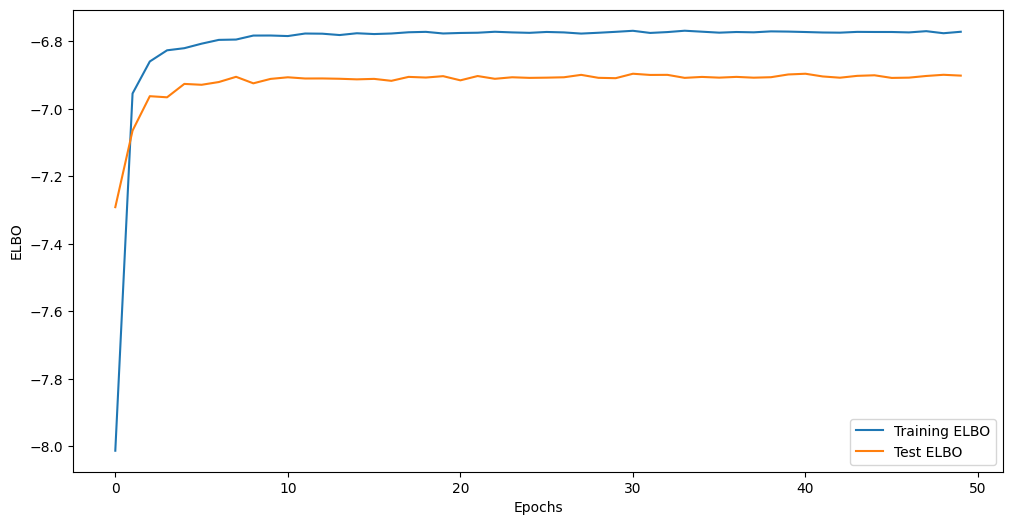

In [9]:
# Plot the ELBO for check overfitting
plt.figure(figsize=(12, 6))
plt.plot(train_elbo_history, label='Training ELBO')
plt.plot(test_elbo_history, label='Test ELBO')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

In [10]:
# Grisha, we need to write the encryptor function from the data obtained at the output of the neuron after its training 

In [11]:
names = ["simples_nodes","simples_linkers","simples","topology","cat","a","b","c","alpha","beta","gamma","cell volume","space group"]

In [12]:
import csv

In [13]:
def csv_to_dict(file):
    d = {}
    with open(file,'r') as data:
        for line in csv.reader(data):
            #print(line, name)
            d[line[0]] = float(line[-1])
    return d

In [14]:
dicts = []
for name in names:
    dicts.append(csv_to_dict(f"{name}.csv"))

In [15]:
model.set_encrypt_params(names, dicts)

In [19]:
encrypt_res, possibilities = model.encrypt(test_dataset)

In [17]:
d1 = dicts[0].items()

In [18]:
list(d1).pop()

("['[O]123[O]45[Zr]6789%101[O]1%11[O]%126[Zr]6%13%14%15%161[O]1%17[O]%186[Zr]6%19%20%21%221[O]1%23[O]%246[Zr]6%25241([O]17[O]86[Zr]2%11%12%23%241[O]%13%19[O]%14%202)[O]1%21[O]%22%25[Zr]235%17%181[O]9%15[O]%10%162'",
 1.0)

In [21]:
possibilities

[[[100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100]],
 [[100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100]],
 [[100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100]],
 [[100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100]],
 [[100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100]],
 [[100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
  [100, 100],
 